In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

In [2]:
from data_loader import load_data

df_raw = load_data(r"data\assets.csv", output_path=r"data\assets_clean.csv")

print("\n✓ Data loading and cleaning complete!")
print(f"Cleaned data shape: {df_raw.shape}")
print(f"Saved to: data/assets_clean.csv")

DATA LOADING AND CLEANING

[LOAD] CSV loaded: 741 rows, 7 columns
[LOAD] Date range: 2021-01-01 00:00:00 to 2023-12-29 00:00:00
[SORT] Data sorted chronologically by Date

[DIAGNOSTICS] Missing values BEFORE cleaning:
Asset_A    21
Asset_B    21
Asset_C    24
Asset_D    18
Asset_E    29
Asset_F    21
dtype: int64

[CLEAN] Forward fill applied to all columns
[CLEAN] No rows dropped after forward fill

[DIAGNOSTICS] Missing values AFTER cleaning:
None detected ✓

[FINAL] Clean dataset shape: 741 rows, 7 columns
[FINAL] Date range: 2021-01-01 00:00:00 to 2023-12-29 00:00:00
[FINAL] 741 trading days available
[SAVE] Clean data saved to 'data\assets_clean.csv'

✓ Data loading and cleaning complete!
Cleaned data shape: (741, 7)
Saved to: data/assets_clean.csv


In [3]:
df = pd.read_csv('data/assets_clean.csv')
df['Date'] = pd.to_datetime(df['Date'])

print(f"\nShape: {df.shape[0]} trading days, {df.shape[1] - 1} assets")
print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"\nAssets: {', '.join(df.columns[1:].tolist())}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nLast 5 rows:")
print(df.tail())


Shape: 741 trading days, 6 assets
Date range: 2021-01-01 to 2023-12-29

Assets: Asset_A, Asset_B, Asset_C, Asset_D, Asset_E, Asset_F

First 5 rows:
        Date    Asset_A     Asset_B    Asset_C     Asset_D     Asset_E  \
0 2021-01-01  97.631673  151.834946  81.354211  203.745418  119.902761   
1 2021-01-04  98.121243  151.888338  79.749046  204.263460  121.796180   
2 2021-01-05  96.641989  151.612705  81.664618  204.263460  125.370824   
3 2021-01-06  95.975767  150.843503  80.797249  203.215367  126.889207   
4 2021-01-07  96.298141  150.929801  81.094938  204.805473  127.903711   

     Asset_F  
0  61.449194  
1  61.313568  
2  59.737493  
3  60.556546  
4  58.966432  

Last 5 rows:
          Date    Asset_A     Asset_B    Asset_C     Asset_D     Asset_E  \
736 2023-12-25  83.745407  167.392147  65.583613  182.509844  105.057410   
737 2023-12-26  81.817517  164.974984  65.583613  179.958332  107.403662   
738 2023-12-27  83.826644  163.661904  65.756751  174.404495  109.774965  

In [4]:
def compute_strategy(df: pd.DataFrame, lookback_days: int) -> Dict[str, pd.Series | pd.DataFrame]:
    
    # Define date and asset col
    date_col = df.columns[0]
    asset_cols = df.columns[1:].tolist()
    data = df.copy()


    data[date_col] = pd.to_datetime(data[date_col])


    daily_returns = data[asset_cols].pct_change()
    momentum_scores = (data[asset_cols] / data[asset_cols].shift(lookback_days)) - 1


    data['year_month'] = data[date_col].dt.to_period('M')
    rebalance_mask = data.groupby('year_month').cumcount() == 0
    rebalance_indices = data.loc[rebalance_mask].index.tolist()
    weights = pd.DataFrame(0.0, index=data.index, columns=asset_cols)


    for i, rebal_pos in enumerate(rebalance_indices):
        momentum_row = momentum_scores.iloc[rebal_pos]
        valid_momentum_count = momentum_row.notna().sum()
        if valid_momentum_count >= 2:
            top_2_assets = momentum_row.nlargest(2).index.tolist()
            start_pos = rebal_pos
            end_pos = rebalance_indices[i + 1] if i + 1 < len(rebalance_indices) else len(data)
            for asset in top_2_assets:
                weights.iloc[start_pos:end_pos, weights.columns.get_loc(asset)] = 0.5

    portfolio_returns = (daily_returns * weights).sum(axis=1)
    portfolio_value = (1 + portfolio_returns).cumprod()

    return {
        'portfolio_returns': portfolio_returns,
        'portfolio_value': portfolio_value,
        'weights': weights
    }

print("Strategy engine loaded successfully!")

Strategy engine loaded successfully!


In [5]:
result_a = compute_strategy(df, lookback_days=30)

print(f"\n[EXECUTION] Strategy A:- Lookback: 30 days")
print(f"  Total trading days: {result_a['portfolio_returns'].shape[0]}")

print(f"\n[SUMMARY] Overall Portfolio Performance:")
print(f"  Final portfolio value: {result_a['portfolio_value'].iloc[-1]:.4f}")
print(f"  Total return: {(result_a['portfolio_value'].iloc[-1] - 1) * 100:.2f}%")
print(f"  Mean daily return: {result_a['portfolio_returns'].mean() * 100:.4f}%")
print(f"  Std dev daily return: {result_a['portfolio_returns'].std() * 100:.4f}%")
print(f"  Sharpe Ratio (annualized): {(result_a['portfolio_returns'].mean() / result_a['portfolio_returns'].std()) * np.sqrt(252):.2f}")


[EXECUTION] Strategy A:- Lookback: 30 days
  Total trading days: 741

[SUMMARY] Overall Portfolio Performance:
  Final portfolio value: 0.5128
  Total return: -48.72%
  Mean daily return: -0.0802%
  Std dev daily return: 1.4026%
  Sharpe Ratio (annualized): -0.91


In [6]:
result_b = compute_strategy(df, lookback_days=90)

print(f"\n[EXECUTION] Strategy B:- Lookback: 90 days")
print(f"  Total trading days: {result_b['portfolio_returns'].shape[0]}")

print(f"\n[SUMMARY] Overall Portfolio Performance:")
print(f"  Final portfolio value: {result_b['portfolio_value'].iloc[-1]:.4f}")
print(f"  Total return: {(result_b['portfolio_value'].iloc[-1] - 1) * 100:.2f}%")
print(f"  Mean daily return: {result_b['portfolio_returns'].mean() * 100:.4f}%")
print(f"  Std dev daily return: {result_b['portfolio_returns'].std() * 100:.4f}%")
print(f"  Sharpe Ratio (annualized): {(result_b['portfolio_returns'].mean() / result_b['portfolio_returns'].std()) * np.sqrt(252):.2f}")


[EXECUTION] Strategy B:- Lookback: 90 days
  Total trading days: 741

[SUMMARY] Overall Portfolio Performance:
  Final portfolio value: 0.8206
  Total return: -17.94%
  Mean daily return: -0.0173%
  Std dev daily return: 1.3712%
  Sharpe Ratio (annualized): -0.20


In [6]:
def extract_monthly_performance(df, portfolio_value, weights):
    results_df = pd.DataFrame({
        'Date': df['Date'].values,
        'PortfolioValue': portfolio_value.values
    })
    
    for col in weights.columns:
        results_df[col] = weights[col].values
    
    results_df['YearMonth'] = results_df['Date'].dt.to_period('M')
    monthly = results_df.groupby('YearMonth').agg({
        'Date': 'last',
        'PortfolioValue': 'last'
    }).reset_index()
    
    monthly['PrevValue'] = monthly['PortfolioValue'].shift(1)
    monthly['MonthlyReturn'] = (monthly['PortfolioValue'] / monthly['PrevValue'] - 1) * 100
    monthly.loc[0, 'MonthlyReturn'] = (monthly.loc[0, 'PortfolioValue'] - 1) * 100
    
    asset_cols = weights.columns.tolist()
    for asset in asset_cols:
        monthly[f'{asset}_weight'] = results_df.groupby('YearMonth')[asset].last().values
    
    return monthly

monthly_a = extract_monthly_performance(df, result_a['portfolio_value'], result_a['weights'])
monthly_b = extract_monthly_performance(df, result_b['portfolio_value'], result_b['weights'])

In [7]:
display_a = monthly_a[['YearMonth', 'PortfolioValue', 'MonthlyReturn']].copy()
display_a.columns = ['Month', 'Portfolio Value', 'Monthly Return %']
display_a['Monthly Return %'] = display_a['Monthly Return %'].apply(lambda x: f"{x:.2f}%")
display_a['Portfolio Value'] = display_a['Portfolio Value'].apply(lambda x: f"{x:.4f}")

print("STRATEGY A: MONTHLY PERFORMANCE (30-Day Lookback)")
print(display_a.to_string(index=False))

STRATEGY A: MONTHLY PERFORMANCE (30-Day Lookback)
  Month Portfolio Value Monthly Return %
2021-01          1.0000            0.00%
2021-02          1.0000            0.00%
2021-03          0.9841           -1.59%
2021-04          1.0088            2.51%
2021-05          1.0854            7.60%
2021-06          1.0017           -7.72%
2021-07          0.9453           -5.63%
2021-08          0.9160           -3.10%
2021-09          0.8582           -6.31%
2021-10          0.8364           -2.54%
2021-11          0.8622            3.09%
2021-12          0.8685            0.73%
2022-01          0.7479          -13.89%
2022-02          0.7288           -2.54%
2022-03          0.7690            5.51%
2022-04          0.8588           11.69%
2022-05          0.8240           -4.06%
2022-06          0.8515            3.34%
2022-07          0.7741           -9.09%
2022-08          0.7860            1.54%
2022-09          0.8044            2.34%
2022-10          0.7351           -8.62%
2022-11

In [8]:
display_b = monthly_b[['YearMonth', 'PortfolioValue', 'MonthlyReturn']].copy()
display_b.columns = ['Month', 'Portfolio Value', 'Monthly Return %']
display_b['Monthly Return %'] = display_b['Monthly Return %'].apply(lambda x: f"{x:.2f}%")
display_b['Portfolio Value'] = display_b['Portfolio Value'].apply(lambda x: f"{x:.4f}")

print("\nSTRATEGY B: MONTHLY PERFORMANCE (90-Day Lookback)")
print(display_b.to_string(index=False))


STRATEGY B: MONTHLY PERFORMANCE (90-Day Lookback)
  Month Portfolio Value Monthly Return %
2021-01          1.0000            0.00%
2021-02          1.0000            0.00%
2021-03          1.0000            0.00%
2021-04          1.0000            0.00%
2021-05          1.0000            0.00%
2021-06          0.9228           -7.72%
2021-07          0.9790            6.08%
2021-08          1.0393            6.16%
2021-09          0.9862           -5.11%
2021-10          0.9777           -0.86%
2021-11          0.9270           -5.19%
2021-12          0.9241           -0.31%
2022-01          0.8884           -3.87%
2022-02          0.9019            1.52%
2022-03          0.9241            2.46%
2022-04          1.0271           11.14%
2022-05          0.9421           -8.27%
2022-06          0.9110           -3.30%
2022-07          0.9070           -0.44%
2022-08          0.8121          -10.47%
2022-09          0.8468            4.28%
2022-10          0.8056           -4.87%
2022-1

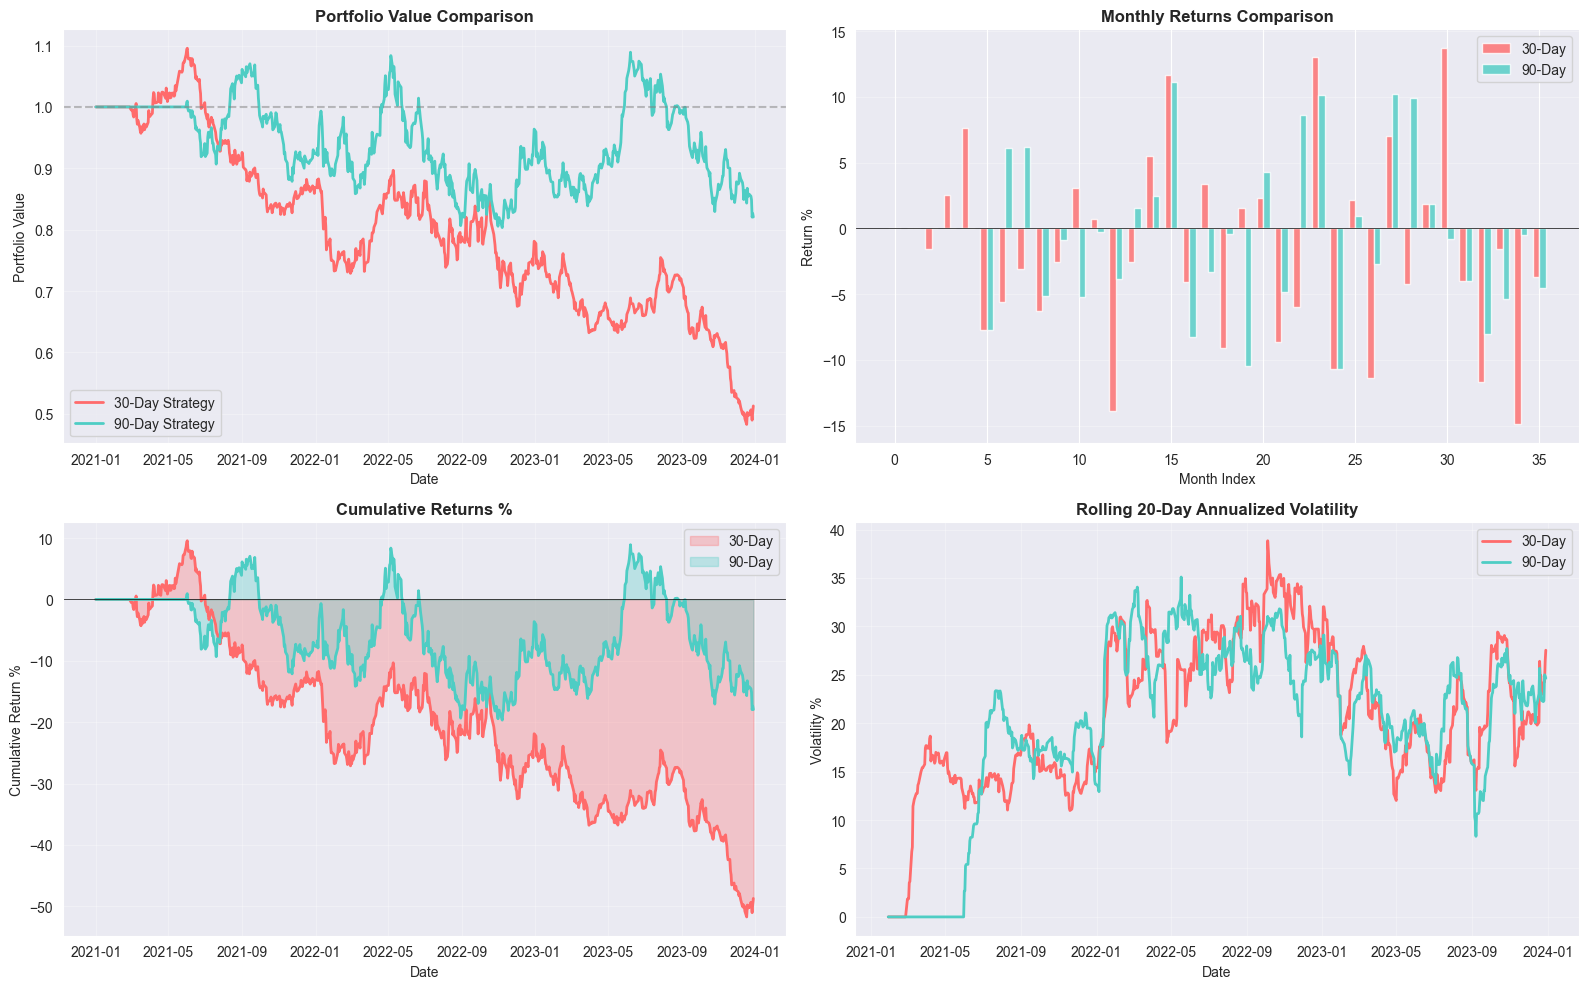

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

ax1 = axes[0, 0]
ax1.plot(df['Date'], result_a['portfolio_value'], label='30-Day Strategy', linewidth=2, color='#FF6B6B')
ax1.plot(df['Date'], result_b['portfolio_value'], label='90-Day Strategy', linewidth=2, color='#4ECDC4')
ax1.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax1.set_title('Portfolio Value Comparison', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
ax2 = axes[0, 1]
x = np.arange(len(monthly_a))
width = 0.35
ax2.bar(x - width/2, monthly_a['MonthlyReturn'], width, label='30-Day', color='#FF6B6B', alpha=0.8)
ax2.bar(x + width/2, monthly_b['MonthlyReturn'], width, label='90-Day', color='#4ECDC4', alpha=0.8)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_title('Monthly Returns Comparison', fontsize=12, fontweight='bold')
ax2.set_xlabel('Month Index')
ax2.set_ylabel('Return %')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Cumulative Returns
ax3 = axes[1, 0]
cumulative_a = (result_a['portfolio_value'] - 1) * 100
cumulative_b = (result_b['portfolio_value'] - 1) * 100
ax3.fill_between(df['Date'], cumulative_a, alpha=0.3, color='#FF6B6B', label='30-Day')
ax3.fill_between(df['Date'], cumulative_b, alpha=0.3, color='#4ECDC4', label='90-Day')
ax3.plot(df['Date'], cumulative_a, color='#FF6B6B', linewidth=2)
ax3.plot(df['Date'], cumulative_b, color='#4ECDC4', linewidth=2)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_title('Cumulative Returns %', fontsize=12, fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('Cumulative Return %')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Rolling Volatility
ax4 = axes[1, 1]
rolling_vol_a = result_a['portfolio_returns'].rolling(window=20).std() * np.sqrt(252) * 100
rolling_vol_b = result_b['portfolio_returns'].rolling(window=20).std() * np.sqrt(252) * 100
ax4.plot(df['Date'], rolling_vol_a, label='30-Day', linewidth=2, color='#FF6B6B')
ax4.plot(df['Date'], rolling_vol_b, label='90-Day', linewidth=2, color='#4ECDC4')
ax4.set_title('Rolling 20-Day Annualized Volatility', fontsize=12, fontweight='bold')
ax4.set_xlabel('Date')
ax4.set_ylabel('Volatility %')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('strategy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [10]:
summary_data = {
    'Metric': [
        'Final Portfolio Value',
        'Total Return (%)',
        'Mean Daily Return (%)',
        'Daily Volatility (%)',
        'Annualized Volatility (%)',
        'Sharpe Ratio (Annualized)',
        'Max Drawdown (%)',
        'Best Month (%)',
        'Worst Month (%)',
        'Positive Months',
        'Win Rate (%)',
    ],
    '30-Day Strategy': [
        f"{result_a['portfolio_value'].iloc[-1]:.4f}",
        f"{(result_a['portfolio_value'].iloc[-1] - 1) * 100:.2f}",
        f"{result_a['portfolio_returns'].mean() * 100:.4f}",
        f"{result_a['portfolio_returns'].std() * 100:.4f}",
        f"{result_a['portfolio_returns'].std() * np.sqrt(252) * 100:.2f}",
        f"{(result_a['portfolio_returns'].mean() / result_a['portfolio_returns'].std()) * np.sqrt(252):.2f}",
        f"{((result_a['portfolio_value'] / result_a['portfolio_value'].cummax() - 1) * 100).min():.2f}",
        f"{monthly_a['MonthlyReturn'].max():.2f}",
        f"{monthly_a['MonthlyReturn'].min():.2f}",
        f"{(monthly_a['MonthlyReturn'] > 0).sum()}",
        f"{(monthly_a['MonthlyReturn'] > 0).sum() / len(monthly_a) * 100:.1f}",
    ],
    '90-Day Strategy': [
        f"{result_b['portfolio_value'].iloc[-1]:.4f}",
        f"{(result_b['portfolio_value'].iloc[-1] - 1) * 100:.2f}",
        f"{result_b['portfolio_returns'].mean() * 100:.4f}",
        f"{result_b['portfolio_returns'].std() * 100:.4f}",
        f"{result_b['portfolio_returns'].std() * np.sqrt(252) * 100:.2f}",
        f"{(result_b['portfolio_returns'].mean() / result_b['portfolio_returns'].std()) * np.sqrt(252):.2f}",
        f"{((result_b['portfolio_value'] / result_b['portfolio_value'].cummax() - 1) * 100).min():.2f}",
        f"{monthly_b['MonthlyReturn'].max():.2f}",
        f"{monthly_b['MonthlyReturn'].min():.2f}",
        f"{(monthly_b['MonthlyReturn'] > 0).sum()}",
        f"{(monthly_b['MonthlyReturn'] > 0).sum() / len(monthly_b) * 100:.1f}",
    ]
}

summary_df = pd.DataFrame(summary_data)

print("COMPREHENSIVE PERFORMANCE SUMMARY")
print(summary_df.to_string(index=False))

COMPREHENSIVE PERFORMANCE SUMMARY
                   Metric 30-Day Strategy 90-Day Strategy
    Final Portfolio Value          0.5128          0.8206
         Total Return (%)          -48.72          -17.94
    Mean Daily Return (%)         -0.0802         -0.0173
     Daily Volatility (%)          1.4026          1.3712
Annualized Volatility (%)           22.27           21.77
Sharpe Ratio (Annualized)           -0.91           -0.20
         Max Drawdown (%)          -55.94          -25.86
           Best Month (%)           13.70           11.14
          Worst Month (%)          -14.91          -10.66
          Positive Months              14              12
             Win Rate (%)            38.9            33.3


In [11]:
from metrics import compute_metrics, print_metrics, compute_sharpe_ratio, compute_sortino_ratio

metrics_a = compute_metrics(result_a['portfolio_returns'], result_a['portfolio_value'])
sharpe_a = compute_sharpe_ratio(result_a['portfolio_returns'])
sortino_a = compute_sortino_ratio(result_a['portfolio_returns'])

metrics_b = compute_metrics(result_b['portfolio_returns'], result_b['portfolio_value'])
sharpe_b = compute_sharpe_ratio(result_b['portfolio_returns'])
sortino_b = compute_sortino_ratio(result_b['portfolio_returns'])

print("\nSTRATEGY A: 30-DAY MOMENTUM - DETAILED METRICS")
print_metrics(metrics_a, "Strategy A (30-Day)")
print(f"Sharpe Ratio (annualized):  {sharpe_a:>10.2f}")
print(f"Sortino Ratio (annualized): {sortino_a:>10.2f}")

print("\nSTRATEGY B: 90-DAY MOMENTUM - DETAILED METRICS")
print_metrics(metrics_b, "Strategy B (90-Day)")
print(f"Sharpe Ratio (annualized):  {sharpe_b:>10.2f}")
print(f"Sortino Ratio (annualized): {sortino_b:>10.2f}")


STRATEGY A: 30-DAY MOMENTUM - DETAILED METRICS
               STRATEGY A (30-DAY)                
Total Return                      -48.72%
CAGR                              -20.32%
Annualized Volatility              22.27%
Maximum Drawdown                  -55.94%
Sharpe Ratio (annualized):       -0.91
Sortino Ratio (annualized):      -1.38

STRATEGY B: 90-DAY MOMENTUM - DETAILED METRICS
               STRATEGY B (90-DAY)                
Total Return                      -17.94%
CAGR                               -6.50%
Annualized Volatility              21.77%
Maximum Drawdown                  -25.86%
Sharpe Ratio (annualized):       -0.20
Sortino Ratio (annualized):      -0.32


In [12]:
metrics_comparison = pd.DataFrame({
    'Metric': [
        'Total Return',
        'CAGR',
        'Annualized Volatility',
        'Maximum Drawdown',
        'Sharpe Ratio',
        'Sortino Ratio',
        'Best Month',
        'Worst Month',
        'Positive Months',
        'Win Rate'
    ],
    '30-Day Strategy': [
        f"{metrics_a['total_return']:.2%}",
        f"{metrics_a['cagr']:.2%}",
        f"{metrics_a['volatility']:.2%}",
        f"{metrics_a['max_drawdown']:.2%}",
        f"{sharpe_a:.2f}",
        f"{sortino_a:.2f}",
        f"{monthly_a['MonthlyReturn'].max():.2f}%",
        f"{monthly_a['MonthlyReturn'].min():.2f}%",
        f"{(monthly_a['MonthlyReturn'] > 0).sum()} / {len(monthly_a)}",
        f"{(monthly_a['MonthlyReturn'] > 0).sum() / len(monthly_a) * 100:.1f}%",
    ],
    '90-Day Strategy': [
        f"{metrics_b['total_return']:.2%}",
        f"{metrics_b['cagr']:.2%}",
        f"{metrics_b['volatility']:.2%}",
        f"{metrics_b['max_drawdown']:.2%}",
        f"{sharpe_b:.2f}",
        f"{sortino_b:.2f}",
        f"{monthly_b['MonthlyReturn'].max():.2f}%",
        f"{monthly_b['MonthlyReturn'].min():.2f}%",
        f"{(monthly_b['MonthlyReturn'] > 0).sum()} / {len(monthly_b)}",
        f"{(monthly_b['MonthlyReturn'] > 0).sum() / len(monthly_b) * 100:.1f}%",
    ],
    'Winner': [
        '90-Day' if metrics_b['total_return'] > metrics_a['total_return'] else '30-Day',
        '90-Day' if metrics_b['cagr'] > metrics_a['cagr'] else '30-Day',
        '90-Day' if metrics_b['volatility'] < metrics_a['volatility'] else '30-Day',
        '90-Day' if metrics_b['max_drawdown'] > metrics_a['max_drawdown'] else '30-Day',
        '90-Day' if sharpe_b > sharpe_a else '30-Day',
        '90-Day' if sortino_b > sortino_a else '30-Day',
        '30-Day' if monthly_a['MonthlyReturn'].max() > monthly_b['MonthlyReturn'].max() else '90-Day',
        '30-Day' if monthly_a['MonthlyReturn'].min() > monthly_b['MonthlyReturn'].min() else '90-Day',
        '90-Day' if (monthly_b['MonthlyReturn'] > 0).sum() > (monthly_a['MonthlyReturn'] > 0).sum() else '30-Day',
        '90-Day' if (monthly_b['MonthlyReturn'] > 0).sum() > (monthly_a['MonthlyReturn'] > 0).sum() else '30-Day',
    ]
})

print("\nCOMPREHENSIVE METRICS COMPARISON")
print(metrics_comparison.to_string(index=False))


COMPREHENSIVE METRICS COMPARISON
               Metric 30-Day Strategy 90-Day Strategy Winner
         Total Return         -48.72%         -17.94% 90-Day
                 CAGR         -20.32%          -6.50% 90-Day
Annualized Volatility          22.27%          21.77% 90-Day
     Maximum Drawdown         -55.94%         -25.86% 90-Day
         Sharpe Ratio           -0.91           -0.20 90-Day
        Sortino Ratio           -1.38           -0.32 90-Day
           Best Month          13.70%          11.14% 30-Day
          Worst Month         -14.91%         -10.66% 90-Day
      Positive Months         14 / 36         12 / 36 30-Day
             Win Rate           38.9%           33.3% 30-Day


In [13]:
import json

metrics_json = {
    "strategy_30_day": {
        "total_return": metrics_a['total_return'],
        "cagr": metrics_a['cagr'],
        "max_drawdown": metrics_a['max_drawdown'],
        "volatility": metrics_a['volatility']
    },
    "strategy_90_day": {
        "total_return": metrics_b['total_return'],
        "cagr": metrics_b['cagr'],
        "max_drawdown": metrics_b['max_drawdown'],
        "volatility": metrics_b['volatility']
    }
}

print(json.dumps(metrics_json, indent=2))
print("\nMetrics stored as JSON variable:")
print(f"30-Day Strategy: {metrics_json['strategy_30_day']}")
print(f"90-Day Strategy: {metrics_json['strategy_90_day']}")


{
  "strategy_30_day": {
    "total_return": -0.48717609810938045,
    "cagr": -0.20316991364696024,
    "max_drawdown": -0.5593899773852692,
    "volatility": 0.22265447128379454
  },
  "strategy_90_day": {
    "total_return": -0.17937033466954377,
    "cagr": -0.06501832176578826,
    "max_drawdown": -0.25857949312009143,
    "volatility": 0.21767303253674058
  }
}

Metrics stored as JSON variable:
30-Day Strategy: {'total_return': -0.48717609810938045, 'cagr': -0.20316991364696024, 'max_drawdown': -0.5593899773852692, 'volatility': 0.22265447128379454}
90-Day Strategy: {'total_return': -0.17937033466954377, 'cagr': -0.06501832176578826, 'max_drawdown': -0.25857949312009143, 'volatility': 0.21767303253674058}


In [ ]:
from dotenv import load_dotenv
from ai_analysis import run_ai_analysis, format_analysis_output

load_dotenv()
print("\nAI-POWERED STRATEGY ANALYSIS")


try:
    # Build complete metric dictionaries for AI analysis
    strategy_30_metrics = {
        "total_return": metrics_a['total_return'],
        "cagr": metrics_a['cagr'],
        "max_drawdown": metrics_a['max_drawdown'],
        "volatility": metrics_a['volatility'],
        "sharpe_ratio": sharpe_a,
        "sortino_ratio": sortino_a
    }
    
    strategy_90_metrics = {
        "total_return": metrics_b['total_return'],
        "cagr": metrics_b['cagr'],
        "max_drawdown": metrics_b['max_drawdown'],
        "volatility": metrics_b['volatility'],
        "sharpe_ratio": sharpe_b,
        "sortino_ratio": sortino_b
    }
    
    
    # Run AI analysis
    print("\n[INFO] Calling Gemini API for strategy analysis...\n")
    analysis_text = run_ai_analysis(strategy_30_metrics, strategy_90_metrics)
    formatted_analysis = format_analysis_output(analysis_text)
    print(formatted_analysis)
    
except Exception as e:
    print(f"\n[ERROR] AI analysis failed: {e}")

s:\NiveshBuddy_Assignment\nbenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
s:\NiveshBuddy_Assignment\ai_analysis.py:4: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  import google.generativeai as genai



AI-POWERED STRATEGY ANALYSIS

[INFO] Computed metrics for both strategies
  Strategy 30-day Sharpe Ratio: -0.9083
  Strategy 90-day Sharpe Ratio: -0.2002

[INFO] Calling Gemini API for strategy analysis...

>>> Systematic Strategy Evaluation: Momentum Strategies (30-day vs. 90-day Lookback) <<<

This analysis compares two momentum strategies based on their provided performance metrics.


──────────────────────────────────────────────────────────────────────
  ▶ # 1. PERFORMANCE COMPARISON
──────────────────────────────────────────────────────────────────────


Strategy 90-day significantly outperforms Strategy 30-day across all return and risk-adjusted metrics. Strategy 90-day delivered a total return of -0.179 and a CAGR of -0.065, which, while negative, are substantially better than Strategy 30-day's total return of -0.487 and CAGR of -0.203. In terms of risk-adjusted performance, Strategy 90-day exhibits a Sharpe Ratio of -0.200 and a Sortino Ratio of -0.320. These are considerably